In [34]:
import pandas as pd
import numpy as np 
from tqdm.auto import tqdm
import joblib
import itertools

# 시각화
import matplotlib.pyplot as plt 
import seaborn as sns 
import matplotlib.font_manager as fm

# 전처리
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GroupKFold, KFold, StratifiedKFold, TimeSeriesSplit

# 모델링
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn import tree

import eli5
from eli5.sklearn import PermutationImportance
import wandb

import warnings
warnings.filterwarnings('ignore')

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

In [35]:
train_path = '/data/ephemeral/home/aistages_ml/upstage-ml-regression-07/house_price_pred/data/interim/0122_train_data.csv'
test_path = '/data/ephemeral/home/aistages_ml/upstage-ml-regression-07/house_price_pred/data/interim/0122_test_data.csv'
total_path = '/data/ephemeral/home/aistages_ml/upstage-ml-regression-07/house_price_pred/data/interim/0122_total_data.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_all = pd.read_csv(total_path)

display(df_train)
display(df_test)
display(df_all)

,index,복도유형,난방방식,전용면적,계약일,층,건축년도,x,y,아파트명,...,빌딩간격,거래날차이,2016_ratio,2017_ratio,2018_ratio,2019_ratio,2020_ratio,2021_ratio,2022_ratio,2023_ratio
0,1000333,계단식,개별난방,75.730,1,3,1997,126.827102,37.540240,우림,...,3,0.0,40.951679,42.799615,44.404440,45.772043,46.834695,49.391500,50.592857,52.183484
1,1000334,혼합식,개별난방,58.170,22,6,1997,126.827102,37.540240,우림,...,3,52.0,40.951679,42.799615,44.404440,45.772043,46.834695,49.391500,50.592857,52.183484
2,981256,혼합식,개별난방,74.790,1,11,2005,126.824573,37.535397,빛여울,...,11,0.0,40.951679,42.799615,44.404440,45.772043,46.834695,49.391500,50.592857,52.183484
3,981257,혼합식,개별난방,74.810,5,3,2005,126.824573,37.535397,빛여울,...,11,4.0,40.951679,42.799615,44.404440,45.772043,46.834695,49.391500,50.592857,52.183484
4,981260,혼합식,개별난방,58.320,6,2,2003,126.824573,37.535397,신라이프,...,11,62.0,40.951679,42.799615,44.404440,45.772043,46.834695,49.391500,50.592857,52.183484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1026238,639554,계단식,개별난방,84.789,26,5,2007,127.076248,37.575837,장안힐스테이트,...,24,-4.0,30.388740,32.130818,33.670211,34.817921,35.699034,37.884712,39.031794,40.441286
1026239,639558,혼합식,개별난방,59.928,6,7,2007,127.076248,37.575837,장안힐스테이트,...,24,10.0,30.388740,32.130818,33.670211,34.817921,35.699034,37.884712,39.031794,40.441286
1026240,639564,혼합식,개별난방,59.928,31,12,2007,127.076248,37.575837,장안힐스테이트,...,24,25.0,30.388740,32.130818,33.670211,34.817921,35.699034,37.884712,39.031794,40.441286
1026241,639563,혼합식,개별난방,59.928,28,23,2007,127.076248,37.575837,장안힐스테이트,...,24,-3.0,30.388740,32.130818,33.670211,34.817921,35.699034,37.884712,39.031794,40.441286


,index,복도유형,난방방식,전용면적,계약일,층,건축년도,x,y,아파트명,...,빌딩간격,거래날차이,2016_ratio,2017_ratio,2018_ratio,2019_ratio,2020_ratio,2021_ratio,2022_ratio,2023_ratio
0,8274,혼합식,개별난방,74.86,30,10,2005,126.824802,37.535311,빛여울,...,0,0.0,40.951679,42.799615,44.40444,45.772043,46.834695,49.391500,50.592857,52.183484
1,7965,계단식,개별난방,84.95,4,7,2016,126.824032,37.534109,금하뜨라네,...,6,165.0,40.951679,42.799615,44.40444,45.772043,46.834695,49.391500,50.592857,52.183484
2,7966,계단식,개별난방,84.78,21,3,2016,126.824032,37.534109,금하뜨라네,...,6,48.0,40.951679,42.799615,44.40444,45.772043,46.834695,49.391500,50.592857,52.183484
3,8282,계단식,개별난방,100.30,5,7,2004,126.827975,37.535340,훼미리주상복합,...,0,0.0,40.951679,42.799615,44.40444,45.772043,46.834695,49.391500,50.592857,52.183484
4,7969,복도식,개별난방,59.94,8,3,1996,126.833953,37.528212,신월성원,...,16,78.0,40.951679,42.799615,44.40444,45.772043,46.834695,49.391500,50.592857,52.183484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,8366,계단식,개별난방,84.39,2,3,2003,126.956813,37.537144,삼성하이츠,...,6,774.0,53.522857,57.264589,58.84635,62.704326,64.923778,69.795335,71.995999,75.087369
9268,8452,계단식,개별난방,84.96,21,2,2002,126.960780,37.542132,효창아트빌2차,...,0,0.0,53.522857,57.264589,58.84635,62.704326,64.923778,69.795335,71.995999,75.087369
9269,8420,복도식,개별난방,63.44,12,4,1980,126.975789,37.551850,후암미주,...,6,163.0,53.522857,57.264589,58.84635,62.704326,64.923778,69.795335,71.995999,75.087369
9270,8433,타워형,개별난방,163.27,13,4,2004,126.977340,37.548844,브라운스톤남산,...,4,506.0,53.522857,57.264589,58.84635,62.704326,64.923778,69.795335,71.995999,75.087369


,index,복도유형,난방방식,전용면적,계약일,층,건축년도,x,y,아파트명,...,빌딩간격,거래날차이,2016_ratio,2017_ratio,2018_ratio,2019_ratio,2020_ratio,2021_ratio,2022_ratio,2023_ratio
0,1000333,계단식,개별난방,75.73,1,3,1997,126.827102,37.540240,우림,...,3,0.0,40.951679,42.799615,44.40444,45.772043,46.834695,49.391500,50.592857,52.183484
1,1000334,혼합식,개별난방,58.17,22,6,1997,126.827102,37.540240,우림,...,3,52.0,40.951679,42.799615,44.40444,45.772043,46.834695,49.391500,50.592857,52.183484
2,981256,혼합식,개별난방,74.79,1,11,2005,126.824573,37.535397,빛여울,...,11,0.0,40.951679,42.799615,44.40444,45.772043,46.834695,49.391500,50.592857,52.183484
3,981257,혼합식,개별난방,74.81,5,3,2005,126.824573,37.535397,빛여울,...,11,4.0,40.951679,42.799615,44.40444,45.772043,46.834695,49.391500,50.592857,52.183484
4,981260,혼합식,개별난방,58.32,6,2,2003,126.824573,37.535397,신라이프,...,11,62.0,40.951679,42.799615,44.40444,45.772043,46.834695,49.391500,50.592857,52.183484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,8366,계단식,개별난방,84.39,2,3,2003,126.956813,37.537144,삼성하이츠,...,6,774.0,53.522857,57.264589,58.84635,62.704326,64.923778,69.795335,71.995999,75.087369
1128090,8452,계단식,개별난방,84.96,21,2,2002,126.960780,37.542132,효창아트빌2차,...,0,0.0,53.522857,57.264589,58.84635,62.704326,64.923778,69.795335,71.995999,75.087369
1128091,8420,복도식,개별난방,63.44,12,4,1980,126.975789,37.551850,후암미주,...,6,163.0,53.522857,57.264589,58.84635,62.704326,64.923778,69.795335,71.995999,75.087369
1128092,8433,타워형,개별난방,163.27,13,4,2004,126.977340,37.548844,브라운스톤남산,...,4,506.0,53.522857,57.264589,58.84635,62.704326,64.923778,69.795335,71.995999,75.087369


In [36]:
df_train = df_all[df_all['is_test'] == 0]
df_test = df_all[df_all['is_test'] == 1]

df_train = df_train.sort_values(by='index')
df_test = df_test.sort_values(by='index')

df_train = df_train.set_index('index').rename_axis(None)
df_test = df_test.set_index('index').rename_axis(None)

df_all = pd.concat([df_train, df_test])
display(df_all)

,복도유형,난방방식,전용면적,계약일,층,건축년도,x,y,아파트명,계약년월,...,빌딩간격,거래날차이,2016_ratio,2017_ratio,2018_ratio,2019_ratio,2020_ratio,2021_ratio,2022_ratio,2023_ratio
0,계단식,개별난방,79.97,8,3,1987,127.057210,37.476763,개포6차우성,201712,...,4,-20.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575
1,계단식,개별난방,79.97,22,4,1987,127.057210,37.476763,개포6차우성,201712,...,4,152.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575
2,계단식,개별난방,54.98,28,5,1987,127.057210,37.476763,개포6차우성,201712,...,4,6.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575
3,계단식,개별난방,79.97,3,4,1987,127.057210,37.476763,개포6차우성,201801,...,4,26.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575
4,계단식,개별난방,79.97,8,2,1987,127.057210,37.476763,개포6차우성,201801,...,4,5.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,복도식,개별난방,49.77,22,7,1996,127.093511,37.616533,신내6대주,202307,...,9,7.0,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087
9268,복도식,개별난방,39.84,7,3,1996,127.093511,37.616533,신내6대주,202308,...,9,16.0,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087
9269,혼합식,개별난방,59.76,17,4,1996,127.093511,37.616533,신내6대주,202308,...,9,10.0,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087
9270,복도식,개별난방,39.84,2,9,1996,127.093511,37.616533,신내6대주,202309,...,9,16.0,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087


In [37]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 61 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   복도유형                    1128094 non-null  object 
 1   난방방식                    1128094 non-null  object 
 2   전용면적                    1128094 non-null  float64
 3   계약일                     1128094 non-null  int64  
 4   층                       1128094 non-null  int64  
 5   건축년도                    1128094 non-null  int64  
 6   x                       1128094 non-null  float64
 7   y                       1128094 non-null  float64
 8   아파트명                    1128094 non-null  object 
 9   계약년월                    1128094 non-null  int64  
 10  도로명_x                   1128094 non-null  object 
 11  도로명주소                   1128094 non-null  object 
 12  mean_지상층수               1128094 non-null  float64
 13  sum_세대수                 1128094 non-null  float64
 14  sum_연

In [38]:
df_all = df_all.drop(columns=['도로명_x', '도로명', '도로명_split', '도로명주소'])

In [39]:
df_all.isnull().sum()

복도유형                           0
난방방식                           0
전용면적                           0
계약일                            0
층                              0
건축년도                           0
x                              0
y                              0
아파트명                           0
계약년월                           0
mean_지상층수                      0
sum_세대수                        0
sum_연면적                        0
mean_연면적                       0
mean_높이                        0
sum_건축면적                       0
mean_건축면적                      0
부속건축물수                         0
target                      9272
동                              0
시군구                            0
bus_min_dist                   0
sub_min_dist                   0
한강거리                           0
소비자전세물가지수                      0
소비자월세물가지수                      0
총인구수                           0
연GDP                           0
기준금리                           0
dist_to_nearest_school         0
bus_count_

## 데이터 전처리

### 매매수급동향 컬럼 사용을 위해 2012년 이후(2013~) 데이터만 사용해보자

In [40]:
meme_trend = df_all.loc[df_all['매매수급동향'].isnull() == True]
print(meme_trend['계약년월'].min(), meme_trend['계약년월'].max())

200701 201212


In [41]:
df_all = df_all.loc[df_all['계약년월'].astype('int') >= 201301]
display(df_all)

,복도유형,난방방식,전용면적,계약일,층,건축년도,x,y,아파트명,계약년월,...,빌딩간격,거래날차이,2016_ratio,2017_ratio,2018_ratio,2019_ratio,2020_ratio,2021_ratio,2022_ratio,2023_ratio
0,계단식,개별난방,79.97,8,3,1987,127.057210,37.476763,개포6차우성,201712,...,4,-20.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575
1,계단식,개별난방,79.97,22,4,1987,127.057210,37.476763,개포6차우성,201712,...,4,152.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575
2,계단식,개별난방,54.98,28,5,1987,127.057210,37.476763,개포6차우성,201712,...,4,6.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575
3,계단식,개별난방,79.97,3,4,1987,127.057210,37.476763,개포6차우성,201801,...,4,26.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575
4,계단식,개별난방,79.97,8,2,1987,127.057210,37.476763,개포6차우성,201801,...,4,5.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,복도식,개별난방,49.77,22,7,1996,127.093511,37.616533,신내6대주,202307,...,9,7.0,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087
9268,복도식,개별난방,39.84,7,3,1996,127.093511,37.616533,신내6대주,202308,...,9,16.0,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087
9269,혼합식,개별난방,59.76,17,4,1996,127.093511,37.616533,신내6대주,202308,...,9,10.0,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087
9270,복도식,개별난방,39.84,2,9,1996,127.093511,37.616533,신내6대주,202309,...,9,16.0,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087


In [42]:
df_all = df_all.reset_index(drop=True)
df_all.isnull().sum()

복도유형                           0
난방방식                           0
전용면적                           0
계약일                            0
층                              0
건축년도                           0
x                              0
y                              0
아파트명                           0
계약년월                           0
mean_지상층수                      0
sum_세대수                        0
sum_연면적                        0
mean_연면적                       0
mean_높이                        0
sum_건축면적                       0
mean_건축면적                      0
부속건축물수                         0
target                      9272
동                              0
시군구                            0
bus_min_dist                   0
sub_min_dist                   0
한강거리                           0
소비자전세물가지수                      0
소비자월세물가지수                      0
총인구수                           0
연GDP                           0
기준금리                           0
dist_to_nearest_school         0
bus_count_

### 년도별_세대수당_평균_주차대수 컬럼의 결측치는 각 년도의 평균 주차대수에 해당하는 값으로 채워주자

In [43]:
df_all.loc[df_all['년도별_세대수당_평균_주차대수'].notnull(), ['계약년월', '년도별_세대수당_평균_주차대수', 'sum_세대수']]

,계약년월,년도별_세대수당_평균_주차대수,sum_세대수
0,201712,0.863383,270.0
1,201712,0.863383,270.0
2,201712,0.863383,270.0
3,201801,0.863383,270.0
4,201801,0.863383,270.0
...,...,...,...
798998,202307,0.889888,1609.0
798999,202308,0.889888,1609.0
799000,202308,0.889888,1609.0
799001,202309,0.889888,1609.0


In [44]:
# 년도별_세대수당_평균_주차대수의 결측치가 없는 컬럼을 봤을 때, sum_세대수가 1041.739764에 해당하는 년도별_세대수당_평균_주차대수는 0.853052인것을 확인할 수 있다.
df_all.loc[df_all['년도별_세대수당_평균_주차대수'].isnull()==True, '년도별_세대수당_평균_주차대수'] = 0.853052
df_all.isnull().sum()

복도유형                           0
난방방식                           0
전용면적                           0
계약일                            0
층                              0
건축년도                           0
x                              0
y                              0
아파트명                           0
계약년월                           0
mean_지상층수                      0
sum_세대수                        0
sum_연면적                        0
mean_연면적                       0
mean_높이                        0
sum_건축면적                       0
mean_건축면적                      0
부속건축물수                         0
target                      9272
동                              0
시군구                            0
bus_min_dist                   0
sub_min_dist                   0
한강거리                           0
소비자전세물가지수                      0
소비자월세물가지수                      0
총인구수                           0
연GDP                           0
기준금리                           0
dist_to_nearest_school         0
bus_count_

### 주차대수, k-전체세대수, 세대수당_주차대수 컬럼은 Interpolate 방식을 이용해서 결측치를 채워주자.

In [45]:
df_test[['매매수급동향', '주차대수', 'k-전체세대수', '세대수당_주차대수', '년도별_세대수당_평균_주차대수']].isnull().sum()

매매수급동향                 0
주차대수                6563
k-전체세대수             6562
세대수당_주차대수           6563
년도별_세대수당_평균_주차대수       0
dtype: int64

In [46]:
df_all[['주차대수', 'k-전체세대수', '세대수당_주차대수']] = df_all[['주차대수', 'k-전체세대수', '세대수당_주차대수']].interpolate(method='linear', axis=0)
df_all.isnull().sum()

복도유형                         0
난방방식                         0
전용면적                         0
계약일                          0
층                            0
건축년도                         0
x                            0
y                            0
아파트명                         0
계약년월                         0
mean_지상층수                    0
sum_세대수                      0
sum_연면적                      0
mean_연면적                     0
mean_높이                      0
sum_건축면적                     0
mean_건축면적                    0
부속건축물수                       0
target                    9272
동                            0
시군구                          0
bus_min_dist                 0
sub_min_dist                 0
한강거리                         0
소비자전세물가지수                    0
소비자월세물가지수                    0
총인구수                         0
연GDP                         0
기준금리                         0
dist_to_nearest_school       0
bus_count_500                0
bus_count_1000               0
bus_coun

In [49]:
df_all = df_all.dropna(subset=['주차대수', 'k-전체세대수', '세대수당_주차대수'])

In [50]:
df_all.isnull().sum()

복도유형                         0
난방방식                         0
전용면적                         0
계약일                          0
층                            0
건축년도                         0
x                            0
y                            0
아파트명                         0
계약년월                         0
mean_지상층수                    0
sum_세대수                      0
sum_연면적                      0
mean_연면적                     0
mean_높이                      0
sum_건축면적                     0
mean_건축면적                    0
부속건축물수                       0
target                    9272
동                            0
시군구                          0
bus_min_dist                 0
sub_min_dist                 0
한강거리                         0
소비자전세물가지수                    0
소비자월세물가지수                    0
총인구수                         0
연GDP                         0
기준금리                         0
dist_to_nearest_school       0
bus_count_500                0
bus_count_1000               0
bus_coun

In [52]:
df_all = df_all.reset_index(drop=True)
display(df_all)

,복도유형,난방방식,전용면적,계약일,층,건축년도,x,y,아파트명,계약년월,...,빌딩간격,거래날차이,2016_ratio,2017_ratio,2018_ratio,2019_ratio,2020_ratio,2021_ratio,2022_ratio,2023_ratio
0,계단식,개별난방,79.97,4,3,1987,127.057210,37.476763,개포6차우성,202112,...,4,93.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575
1,계단식,개별난방,79.97,12,4,1987,127.057210,37.476763,개포6차우성,202204,...,4,129.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575
2,계단식,개별난방,79.97,21,2,1987,127.057210,37.476763,개포6차우성,202204,...,4,9.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575
3,계단식,개별난방,79.97,27,2,1987,127.057210,37.476763,개포6차우성,202205,...,4,36.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575
4,계단식,개별난방,54.98,4,1,1987,127.057210,37.476763,개포6차우성,202012,...,4,101.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798986,복도식,개별난방,49.77,22,7,1996,127.093511,37.616533,신내6대주,202307,...,9,7.0,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087
798987,복도식,개별난방,39.84,7,3,1996,127.093511,37.616533,신내6대주,202308,...,9,16.0,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087
798988,혼합식,개별난방,59.76,17,4,1996,127.093511,37.616533,신내6대주,202308,...,9,10.0,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087
798989,복도식,개별난방,39.84,2,9,1996,127.093511,37.616533,신내6대주,202309,...,9,16.0,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087


In [53]:
numeric_cols = df_all.select_dtypes(np.number)
categorical_cols = df_all.select_dtypes('object')

display(numeric_cols)
display(categorical_cols)

,전용면적,계약일,층,건축년도,x,y,계약년월,mean_지상층수,sum_세대수,sum_연면적,...,빌딩간격,거래날차이,2016_ratio,2017_ratio,2018_ratio,2019_ratio,2020_ratio,2021_ratio,2022_ratio,2023_ratio
0,79.97,4,3,1987,127.057210,37.476763,202112,5.00,270.0,21960.54,...,4,93.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575
1,79.97,12,4,1987,127.057210,37.476763,202204,5.00,270.0,21960.54,...,4,129.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575
2,79.97,21,2,1987,127.057210,37.476763,202204,5.00,270.0,21960.54,...,4,9.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575
3,79.97,27,2,1987,127.057210,37.476763,202205,5.00,270.0,21960.54,...,4,36.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575
4,54.98,4,1,1987,127.057210,37.476763,202012,5.00,270.0,21960.54,...,4,101.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798986,49.77,22,7,1996,127.093511,37.616533,202307,11.25,1609.0,127417.74,...,9,7.0,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087
798987,39.84,7,3,1996,127.093511,37.616533,202308,11.25,1609.0,127417.74,...,9,16.0,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087
798988,59.76,17,4,1996,127.093511,37.616533,202308,11.25,1609.0,127417.74,...,9,10.0,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087
798989,39.84,2,9,1996,127.093511,37.616533,202309,11.25,1609.0,127417.74,...,9,16.0,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087


,복도유형,난방방식,아파트명,동,시군구
0,계단식,개별난방,개포6차우성,개포동,서울특별시 강남구 개포동
1,계단식,개별난방,개포6차우성,개포동,서울특별시 강남구 개포동
2,계단식,개별난방,개포6차우성,개포동,서울특별시 강남구 개포동
3,계단식,개별난방,개포6차우성,개포동,서울특별시 강남구 개포동
4,계단식,개별난방,개포6차우성,개포동,서울특별시 강남구 개포동
...,...,...,...,...,...
798986,복도식,개별난방,신내6대주,신내동,서울특별시 중랑구 신내동
798987,복도식,개별난방,신내6대주,신내동,서울특별시 중랑구 신내동
798988,혼합식,개별난방,신내6대주,신내동,서울특별시 중랑구 신내동
798989,복도식,개별난방,신내6대주,신내동,서울특별시 중랑구 신내동


In [54]:
del df_all['동']
df_all[['시', '구', '동']] = df_all['시군구'].str.split(' ', expand=True)
display(df_all)

,복도유형,난방방식,전용면적,계약일,층,건축년도,x,y,아파트명,계약년월,...,2017_ratio,2018_ratio,2019_ratio,2020_ratio,2021_ratio,2022_ratio,2023_ratio,시,구,동
0,계단식,개별난방,79.97,4,3,1987,127.057210,37.476763,개포6차우성,202112,...,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575,서울특별시,강남구,개포동
1,계단식,개별난방,79.97,12,4,1987,127.057210,37.476763,개포6차우성,202204,...,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575,서울특별시,강남구,개포동
2,계단식,개별난방,79.97,21,2,1987,127.057210,37.476763,개포6차우성,202204,...,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575,서울특별시,강남구,개포동
3,계단식,개별난방,79.97,27,2,1987,127.057210,37.476763,개포6차우성,202205,...,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575,서울특별시,강남구,개포동
4,계단식,개별난방,54.98,4,1,1987,127.057210,37.476763,개포6차우성,202012,...,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575,서울특별시,강남구,개포동
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798986,복도식,개별난방,49.77,22,7,1996,127.093511,37.616533,신내6대주,202307,...,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087,서울특별시,중랑구,신내동
798987,복도식,개별난방,39.84,7,3,1996,127.093511,37.616533,신내6대주,202308,...,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087,서울특별시,중랑구,신내동
798988,혼합식,개별난방,59.76,17,4,1996,127.093511,37.616533,신내6대주,202308,...,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087,서울특별시,중랑구,신내동
798989,복도식,개별난방,39.84,2,9,1996,127.093511,37.616533,신내6대주,202309,...,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087,서울특별시,중랑구,신내동


In [55]:
# 서울특별시에 해당하는 데이터이므로 전부다 서울특별시로 채워져 있다 --> 삭제해도 무방
df_all['시'].unique()
del df_all['시']

### 범주형 변수 Encoding

In [56]:
df_train = df_all[df_all['is_test'] == 0]
df_test = df_all[df_all['is_test'] == 1]

del df_train['is_test']
del df_test['is_test']

display(df_train)
display(df_test)

,복도유형,난방방식,전용면적,계약일,층,건축년도,x,y,아파트명,계약년월,...,2016_ratio,2017_ratio,2018_ratio,2019_ratio,2020_ratio,2021_ratio,2022_ratio,2023_ratio,구,동
0,계단식,개별난방,79.97,4,3,1987,127.057210,37.476763,개포6차우성,202112,...,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575,강남구,개포동
1,계단식,개별난방,79.97,12,4,1987,127.057210,37.476763,개포6차우성,202204,...,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575,강남구,개포동
2,계단식,개별난방,79.97,21,2,1987,127.057210,37.476763,개포6차우성,202204,...,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575,강남구,개포동
3,계단식,개별난방,79.97,27,2,1987,127.057210,37.476763,개포6차우성,202205,...,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575,강남구,개포동
4,계단식,개별난방,54.98,4,1,1987,127.057210,37.476763,개포6차우성,202012,...,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575,강남구,개포동
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789714,복도식,개별난방,18.09,14,4,2013,127.079129,37.593212,베스트엘리시온,201407,...,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087,중랑구,상봉동
789715,복도식,개별난방,30.91,14,7,2013,127.079129,37.593212,베스트엘리시온,201407,...,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087,중랑구,상봉동
789716,복도식,개별난방,30.91,14,4,2013,127.079129,37.593212,베스트엘리시온,201407,...,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087,중랑구,상봉동
789717,복도식,개별난방,18.09,14,3,2013,127.079129,37.593212,베스트엘리시온,201407,...,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087,중랑구,상봉동


,복도유형,난방방식,전용면적,계약일,층,건축년도,x,y,아파트명,계약년월,...,2016_ratio,2017_ratio,2018_ratio,2019_ratio,2020_ratio,2021_ratio,2022_ratio,2023_ratio,구,동
789719,계단식,개별난방,79.97,26,5,1987,127.057210,37.476763,개포6차우성,202307,...,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575,강남구,개포동
789720,혼합식,지역난방,161.00,28,15,1984,127.055990,37.483894,개포우성3차,202307,...,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575,강남구,개포동
789721,혼합식,지역난방,133.46,10,14,1984,127.055990,37.483894,개포우성3차,202308,...,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575,강남구,개포동
789722,혼합식,지역난방,104.43,18,6,1984,127.055990,37.483894,개포우성3차,202308,...,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575,강남구,개포동
789723,복도식,지역난방,74.25,28,8,1983,127.068028,37.487802,개포주공5단지,202307,...,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575,강남구,개포동
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798986,복도식,개별난방,49.77,22,7,1996,127.093511,37.616533,신내6대주,202307,...,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087,중랑구,신내동
798987,복도식,개별난방,39.84,7,3,1996,127.093511,37.616533,신내6대주,202308,...,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087,중랑구,신내동
798988,혼합식,개별난방,59.76,17,4,1996,127.093511,37.616533,신내6대주,202308,...,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087,중랑구,신내동
798989,복도식,개별난방,39.84,2,9,1996,127.093511,37.616533,신내6대주,202309,...,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087,중랑구,신내동


In [57]:
numeric_cols = df_train.select_dtypes(np.number)
categorical_cols = df_train.select_dtypes('object')

display(numeric_cols)
display(categorical_cols)

,전용면적,계약일,층,건축년도,x,y,계약년월,mean_지상층수,sum_세대수,sum_연면적,...,빌딩간격,거래날차이,2016_ratio,2017_ratio,2018_ratio,2019_ratio,2020_ratio,2021_ratio,2022_ratio,2023_ratio
0,79.97,4,3,1987,127.057210,37.476763,202112,5.0,270.0,21960.54,...,4,93.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575
1,79.97,12,4,1987,127.057210,37.476763,202204,5.0,270.0,21960.54,...,4,129.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575
2,79.97,21,2,1987,127.057210,37.476763,202204,5.0,270.0,21960.54,...,4,9.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575
3,79.97,27,2,1987,127.057210,37.476763,202205,5.0,270.0,21960.54,...,4,36.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575
4,54.98,4,1,1987,127.057210,37.476763,202012,5.0,270.0,21960.54,...,4,101.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789714,18.09,14,4,2013,127.079129,37.593212,201407,8.0,44.0,2576.99,...,5,0.0,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087
789715,30.91,14,7,2013,127.079129,37.593212,201407,8.0,44.0,2576.99,...,5,143.0,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087
789716,30.91,14,4,2013,127.079129,37.593212,201407,8.0,44.0,2576.99,...,5,0.0,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087
789717,18.09,14,3,2013,127.079129,37.593212,201407,8.0,44.0,2576.99,...,5,0.0,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087


,복도유형,난방방식,아파트명,시군구,구,동
0,계단식,개별난방,개포6차우성,서울특별시 강남구 개포동,강남구,개포동
1,계단식,개별난방,개포6차우성,서울특별시 강남구 개포동,강남구,개포동
2,계단식,개별난방,개포6차우성,서울특별시 강남구 개포동,강남구,개포동
3,계단식,개별난방,개포6차우성,서울특별시 강남구 개포동,강남구,개포동
4,계단식,개별난방,개포6차우성,서울특별시 강남구 개포동,강남구,개포동
...,...,...,...,...,...,...
789714,복도식,개별난방,베스트엘리시온,서울특별시 중랑구 상봉동,중랑구,상봉동
789715,복도식,개별난방,베스트엘리시온,서울특별시 중랑구 상봉동,중랑구,상봉동
789716,복도식,개별난방,베스트엘리시온,서울특별시 중랑구 상봉동,중랑구,상봉동
789717,복도식,개별난방,베스트엘리시온,서울특별시 중랑구 상봉동,중랑구,상봉동


In [58]:
# 범주형 변수들을 대상으로 레이블 인코딩 진행

label_encoders = {}

for col in tqdm(categorical_cols):
    lbl = LabelEncoder()

    lbl.fit(df_train[col].astype(str))
    df_train[col] = lbl.transform(df_train[col].astype(str))
    label_encoders[col] = lbl

    for label in np.unique(df_test[col]):
        if label not in lbl.classes_:
            lbl.classes_ = np.append(lbl.classes_, label)

    df_test[col] = lbl.transform(df_test[col].astype(str))

  0%|          | 0/789719 [00:00<?, ?it/s]

In [59]:
display(df_train)
display(df_test)

,복도유형,난방방식,전용면적,계약일,층,건축년도,x,y,아파트명,계약년월,...,2016_ratio,2017_ratio,2018_ratio,2019_ratio,2020_ratio,2021_ratio,2022_ratio,2023_ratio,구,동
0,0,0,79.97,4,3,1987,127.057210,37.476763,318,202112,...,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575,0,8
1,0,0,79.97,12,4,1987,127.057210,37.476763,318,202204,...,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575,0,8
2,0,0,79.97,21,2,1987,127.057210,37.476763,318,202204,...,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575,0,8
3,0,0,79.97,27,2,1987,127.057210,37.476763,318,202205,...,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575,0,8
4,0,0,54.98,4,1,1987,127.057210,37.476763,318,202012,...,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789714,1,0,18.09,14,4,2013,127.079129,37.593212,2459,201407,...,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087,24,143
789715,1,0,30.91,14,7,2013,127.079129,37.593212,2459,201407,...,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087,24,143
789716,1,0,30.91,14,4,2013,127.079129,37.593212,2459,201407,...,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087,24,143
789717,1,0,18.09,14,3,2013,127.079129,37.593212,2459,201407,...,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087,24,143


,복도유형,난방방식,전용면적,계약일,층,건축년도,x,y,아파트명,계약년월,...,2016_ratio,2017_ratio,2018_ratio,2019_ratio,2020_ratio,2021_ratio,2022_ratio,2023_ratio,구,동
789719,0,0,79.97,26,5,1987,127.057210,37.476763,318,202307,...,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575,0,8
789720,3,2,161.00,28,15,1984,127.055990,37.483894,323,202307,...,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575,0,8
789721,3,2,133.46,10,14,1984,127.055990,37.483894,323,202308,...,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575,0,8
789722,3,2,104.43,18,6,1984,127.055990,37.483894,323,202308,...,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575,0,8
789723,1,2,74.25,28,8,1983,127.068028,37.487802,329,202307,...,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798986,1,0,49.77,22,7,1996,127.093511,37.616533,3636,202307,...,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087,24,174
798987,1,0,39.84,7,3,1996,127.093511,37.616533,3636,202308,...,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087,24,174
798988,3,0,59.76,17,4,1996,127.093511,37.616533,3636,202308,...,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087,24,174
798989,1,0,39.84,2,9,1996,127.093511,37.616533,3636,202309,...,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087,24,174


In [60]:
del df_train['시군구']
del df_test['시군구']

In [61]:
display(df_train.info())
display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 789719 entries, 0 to 789718
Data columns (total 56 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   복도유형                    789719 non-null  int64  
 1   난방방식                    789719 non-null  int64  
 2   전용면적                    789719 non-null  float64
 3   계약일                     789719 non-null  int64  
 4   층                       789719 non-null  int64  
 5   건축년도                    789719 non-null  int64  
 6   x                       789719 non-null  float64
 7   y                       789719 non-null  float64
 8   아파트명                    789719 non-null  int64  
 9   계약년월                    789719 non-null  int64  
 10  mean_지상층수               789719 non-null  float64
 11  sum_세대수                 789719 non-null  float64
 12  sum_연면적                 789719 non-null  float64
 13  mean_연면적                789719 non-null  float64
 14  mean_높이             

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9272 entries, 789719 to 798990
Data columns (total 56 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   복도유형                    9272 non-null   int64  
 1   난방방식                    9272 non-null   int64  
 2   전용면적                    9272 non-null   float64
 3   계약일                     9272 non-null   int64  
 4   층                       9272 non-null   int64  
 5   건축년도                    9272 non-null   int64  
 6   x                       9272 non-null   float64
 7   y                       9272 non-null   float64
 8   아파트명                    9272 non-null   int64  
 9   계약년월                    9272 non-null   int64  
 10  mean_지상층수               9272 non-null   float64
 11  sum_세대수                 9272 non-null   float64
 12  sum_연면적                 9272 non-null   float64
 13  mean_연면적                9272 non-null   float64
 14  mean_높이                 9272 non-

None

## 모델링

In [62]:
target_col = 'target'
input_cols = df_train.columns.tolist()
input_cols.remove(target_col)

display(f"Input features : {input_cols}")
display(f"Target : {target_col}")

"Input features : ['복도유형', '난방방식', '전용면적', '계약일', '층', '건축년도', 'x', 'y', '아파트명', '계약년월', 'mean_지상층수', 'sum_세대수', 'sum_연면적', 'mean_연면적', 'mean_높이', 'sum_건축면적', 'mean_건축면적', '부속건축물수', 'bus_min_dist', 'sub_min_dist', '한강거리', '소비자전세물가지수', '소비자월세물가지수', '총인구수', '연GDP', '기준금리', 'dist_to_nearest_school', 'bus_count_500', 'bus_count_1000', 'bus_count_1500', 'bus_count_2000', 'is_station_area', '대장아파트_거리', '전용면적_filtered', '이전가격', '매매수급동향', '주차대수', 'k-전체세대수', '세대수당_주차대수', '년도별_세대수당_평균_주차대수', '건물나이', '최고층', '최저층', '빌딩간격', '거래날차이', '2016_ratio', '2017_ratio', '2018_ratio', '2019_ratio', '2020_ratio', '2021_ratio', '2022_ratio', '2023_ratio', '구', '동']"

'Target : target'

In [63]:
X_train = df_train[input_cols]
Y_train = df_train[target_col]

display(f"Train Input : {X_train.shape}")
display(f"Train Target : {Y_train.shape}")

'Train Input : (789719, 55)'

'Train Target : (789719,)'

In [64]:
X_test = df_test[input_cols]
Y_test = df_test[target_col]

display(f"Test Input : {X_test.shape}")
display(f"Test Target : {Y_test.shape}")

'Test Input : (9272, 55)'

'Test Target : (9272,)'

In [65]:
# 1. KFold로 데이터 split
kf = KFold(n_splits=5)

In [66]:
train_folds = kf.split(X_train, Y_train)
display(train_folds)

<generator object _BaseKFold.split at 0x7f5b487b37d0>

In [67]:
run = wandb.init(project='AIStages-ML', name='lgbm_baseline_kfold')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: leeanghoo2. Use `wandb login --relogin` to force relogin


In [68]:
fold_save_files = []

for fold_idx, (train_idx, valid_idx) in tqdm(enumerate(train_folds)):
    print(f"-------{fold_idx}번째 fold의 학습을 시작합니다.---------")

    X_train_fold = X_train.iloc[train_idx, :]
    Y_train_fold = Y_train.iloc[train_idx]

    X_valid_fold = X_train.iloc[valid_idx, :]
    Y_valid_fold = Y_train.iloc[valid_idx]

    # fold의 데이터로 학습을 진행
    gbm = lgb.LGBMRegressor(n_estimators=10000)
    gbm.fit(X_train_fold, Y_train_fold,
            eval_set=[(X_train_fold, Y_train_fold), (X_valid_fold, Y_valid_fold)],
            eval_metric='rmse',
            callbacks=[lgb.early_stopping(stopping_rounds=10),
                       lgb.log_evaluation(period=100, show_stdv=True)])
    
    monitoring_value = {
                        'train_rmse' : gbm.evals_result_['training']['rmse'][-1],
                        'valid_rmse' : gbm.evals_result_['valid_1']['rmse'][-1]
                        }
    run.log(monitoring_value)
    
    # 각 fold별 학습한 모델을 저장.
    file_path = '../models/'
    file_name = f'kfold{fold_idx}_baseline_gbm.pkl'
    joblib.dump(gbm, file_path+file_name)
    print(f"----------{fold_idx}번째 fold는 {file_name}에 저장되었습니다.-------\n\n")
    fold_save_files.append(file_name)
    

0it [00:00, ?it/s]

-------0번째 fold의 학습을 시작합니다.---------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7430
[LightGBM] [Info] Number of data points in the train set: 631775, number of used features: 55
[LightGBM] [Info] Start training from score 61197.871275
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[57]	training's rmse: 8273.37	training's l2: 6.84487e+07	valid_1's rmse: 14524.7	valid_1's l2: 2.10967e+08
----------0번째 fold는 kfold0_baseline_gbm.pkl에 저장되었습니다.-------


-------1번째 fold의 학습을 시작합니다.---------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total

In [69]:
for file_name in fold_save_files:
    run.save(file_name + file_name)

run.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


train_rmse,▃▂█▁▇
valid_rmse,█▂▁▆▇
train_rmse,8612.94641
valid_rmse,13375.24529


In [70]:
# 1, 2
top2_files = [file_path+'kfold1_baseline_gbm.pkl', file_path+'kfold2_baseline_gbm.pkl']
total_predicts = np.zeros(len(X_test))

for file_name in top2_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    total_predicts += fold_predicts

total_predicts /= len(top2_files)

In [71]:
preds_df = pd.DataFrame(total_predicts.astype(int), columns=['target'])
preds_df.to_csv('../data/interim/kfold_lgbm_baseline_output.csv', index=False)

## Feature Selection

In [74]:
feat_imp = gbm.feature_importances_
sorted_feat_imp = pd.Series(feat_imp, input_cols).sort_values(ascending=False)
print(sorted_feat_imp)

이전가격                      482
계약년월                      297
전용면적                      204
2016_ratio                 82
건축년도                       69
층                          67
sum_연면적                    57
매매수급동향                     50
전용면적_filtered              50
한강거리                       29
대장아파트_거리                   22
bus_count_1000             21
y                          19
mean_연면적                   16
mean_높이                    16
bus_count_500              15
sum_건축면적                   15
sum_세대수                    15
x                          14
거래날차이                      12
2017_ratio                 11
기준금리                        9
bus_count_1500              9
2020_ratio                  9
mean_건축면적                   7
건물나이                        7
2018_ratio                  7
소비자월세물가지수                   7
년도별_세대수당_평균_주차대수            7
아파트명                        7
mean_지상층수                   7
2019_ratio                  6
세대수당_주차대수                   6
최고층       

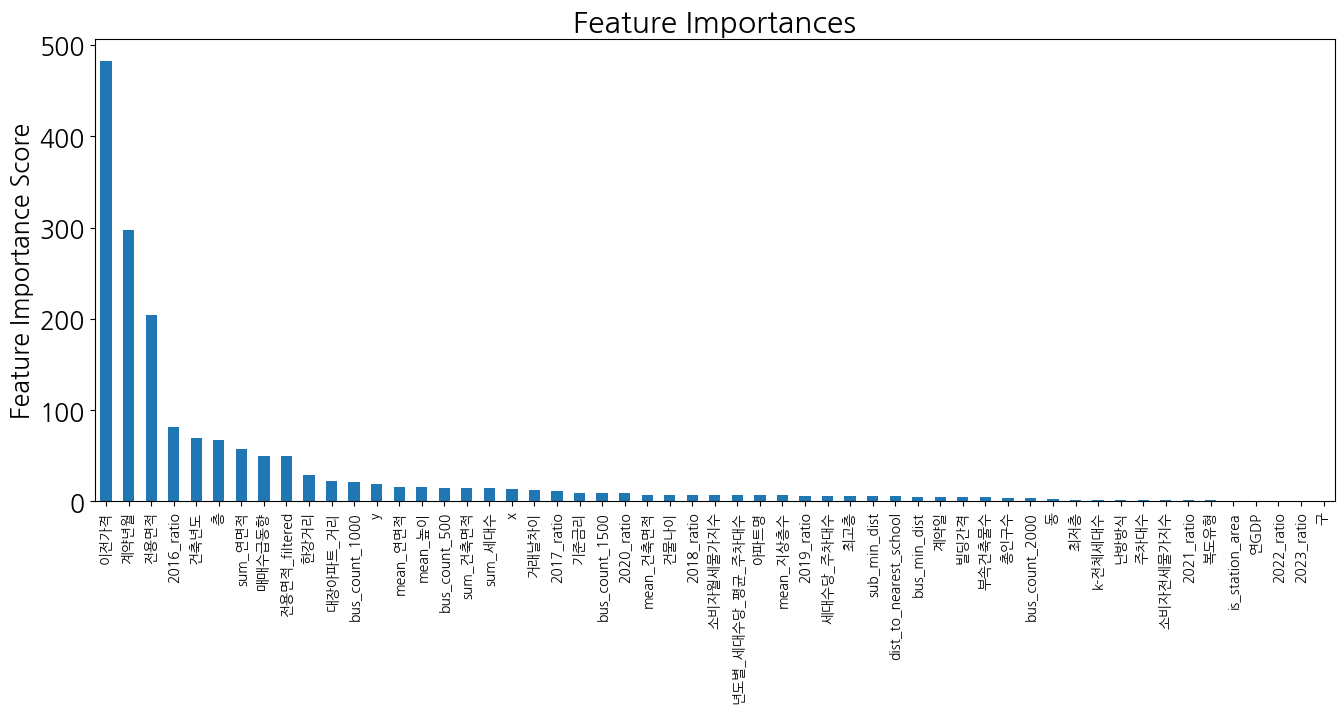

In [78]:
plt.figure(figsize=(16, 6))
sorted_feat_imp.plot(kind='bar')
plt.title('Feature Importances')
plt.ylabel('Feature Importance Score')
plt.xticks(fontsize=10)
plt.show()

- Feature Importances가 5 이하인 컬럼 제거
    - 총인구수
    - bus_count_2000
    - 동
    - 최저층
    - K-전체세대수
    - 난방방식
    - 주차대수
    - 소비자전세물가지수
    - 2021_ratio
    - 복도유형
    - is_station_area
    - 연 GDP
    - 2022_ratio
    - 2023_ratio
    - 구

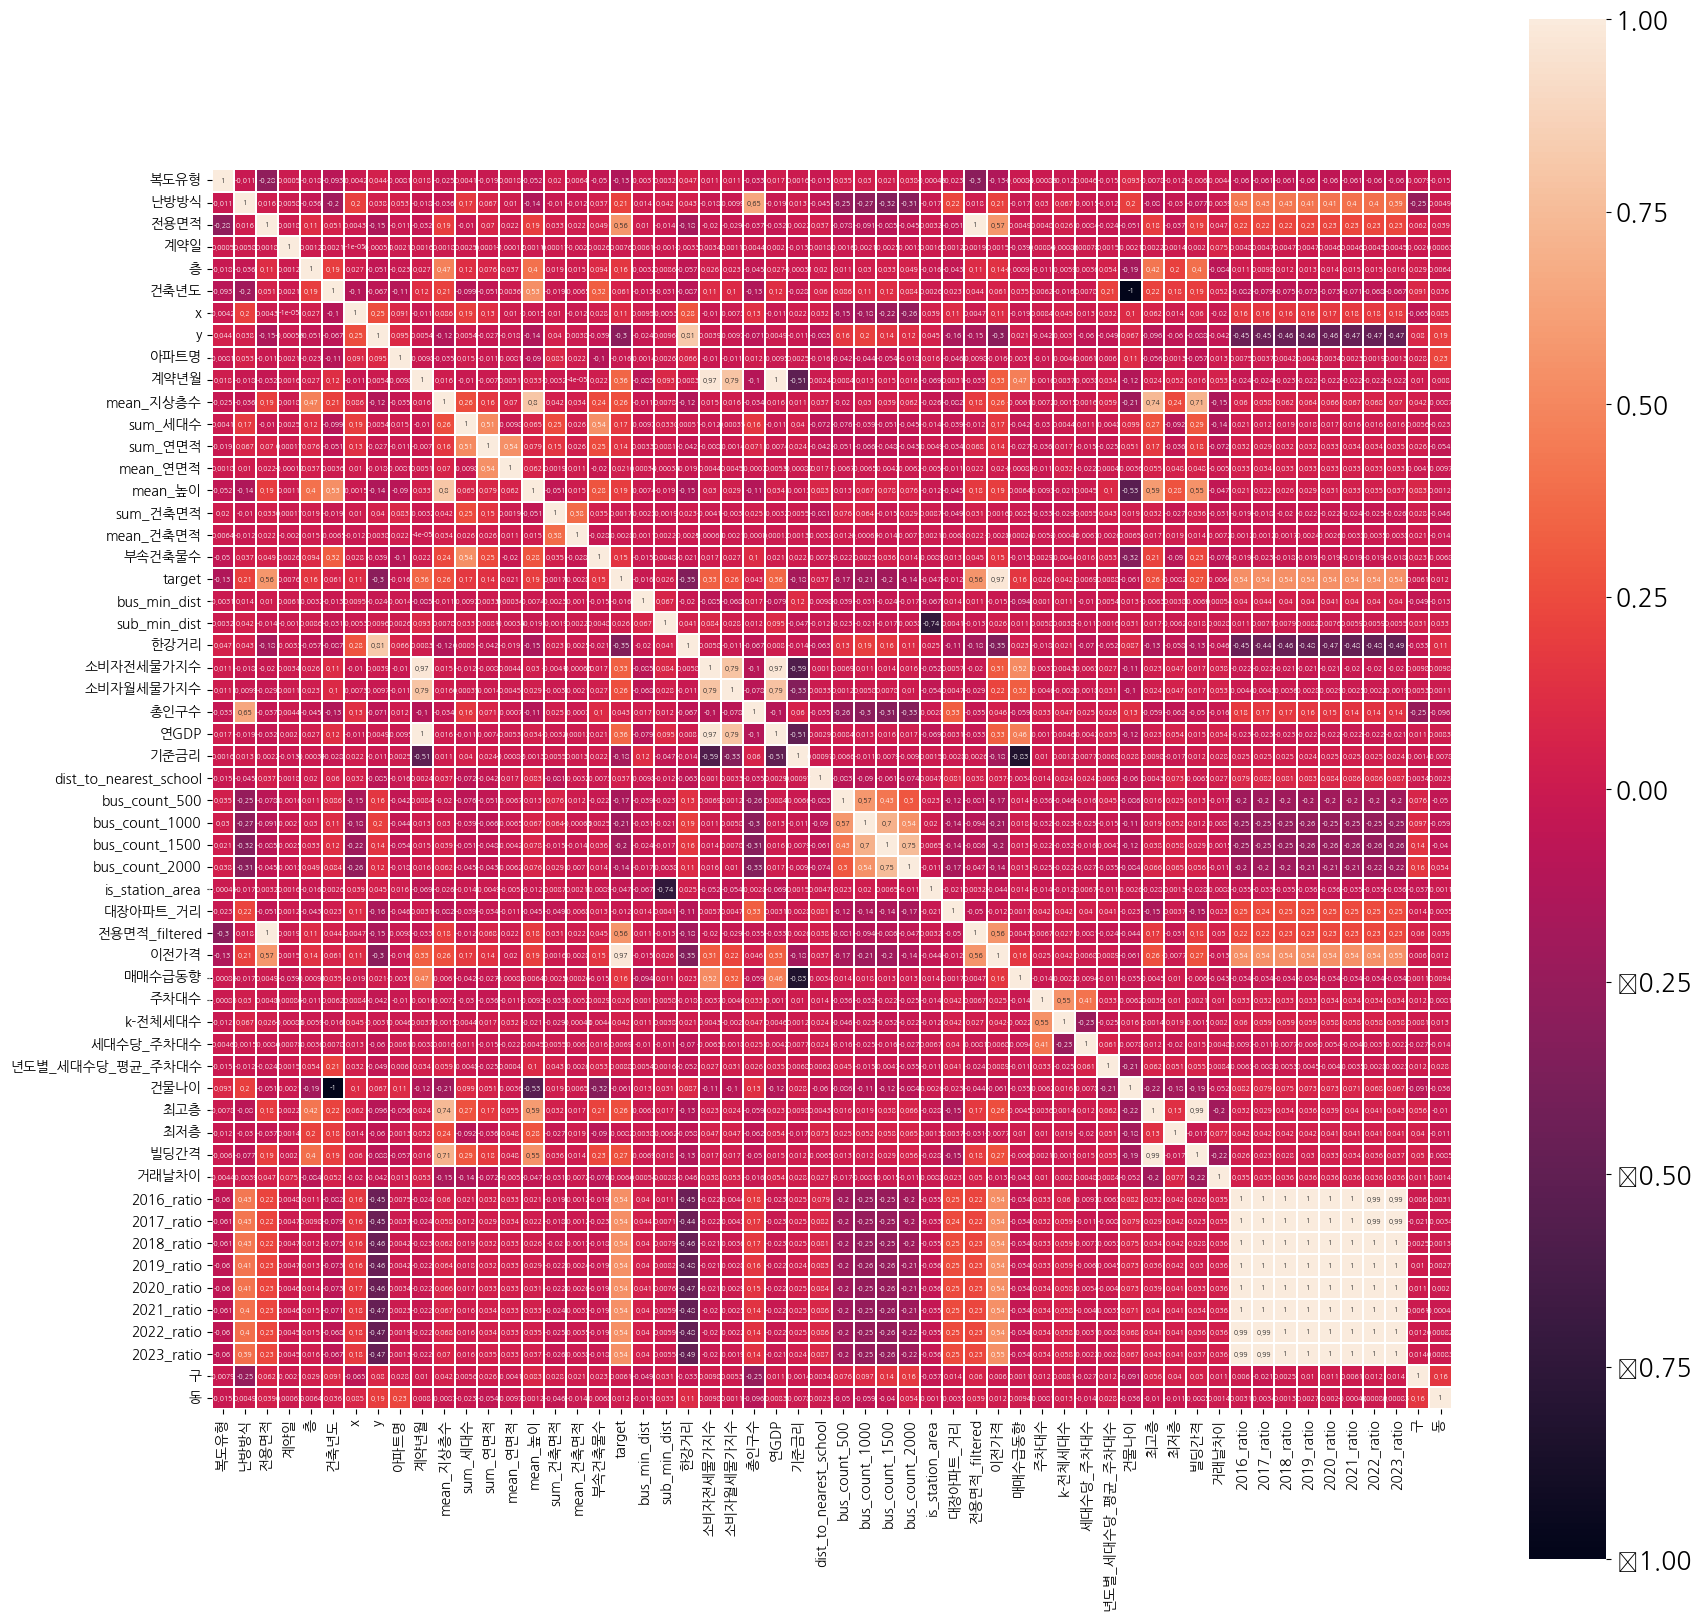

In [88]:
corr = df_train.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, annot_kws={'size' : 5}, square=True, linewidths=0.2, fmt=".2g", xticklabels=df_train.columns)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

- x_ratio의 상관관계가 거의 다 1이므로 이중 2020_ratio만 남기고 나머지 컬럼은 삭제
- 빌딩간격과 최고층의 상관관계가 0.99로 강한 양의 상관관계를 갖는다 --> 빌딩간격 컬럼 제거
- 지하철역 최소 거리와 역세권 여부는 -0.74로 강한 음의 상관관계를 보인다 --> 역세권 여부 제거
- 건물나이는 mean_높이와 건축년도와 강한 음의 상관관계를 가진다 -> 건물나이 하나로 다른 두 컬럼을 대변 가능 -> 건축년도, mean_높이 컬럼 제거
- 기준 금리와 매매급수동향은 강한 음의 상관관계를 가진다 -> 기준 금리 컬럼 제거
- bus count도 각 변수별로 비례하는 양의 상관관계를 가진다 --> Feature Importance가 가장 높았던 bus_1500 변수를 제외하고 다 제거


### Permutation Importance 기반 Selection

In [90]:
model = joblib.load('/data/ephemeral/home/aistages_ml/upstage-ml-regression-07/house_price_pred/models/kfold2_baseline_gbm.pkl')


In [94]:
perm = PermutationImportance(model, 
                            scoring='neg_root_mean_squared_error',
                            random_state=42,
                            n_iter=5).fit(X_valid_fold, Y_valid_fold)

eli5.show_weights(perm, feature_names = X_valid_fold.columns.tolist())

Weight,Feature
50678.8511 ± 142.3206,이전가격
8625.0571 ± 142.2375,계약년월
2984.8630 ± 93.0163,전용면적
1848.8138 ± 6.7421,전용면적_filtered
685.2801 ± 19.5501,2016_ratio
554.6980 ± 39.8605,건축년도
533.4039 ± 32.3839,sum_연면적
367.3920 ± 25.6669,층
361.7769 ± 24.5155,한강거리
333.7228 ± 15.4257,대장아파트_거리
